In [1]:
from torchvision.datasets import Cityscapes
import torch
import torch.nn as nn
import torchvision.models as models
import segmentation_models_pytorch as smp

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor

from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import gc

### read dataset

In [2]:
dataset_raw = Cityscapes('./data', split='train', mode='fine',
                      target_type='semantic')

In [3]:
dataset_raw[0][0].size

(2048, 1024)

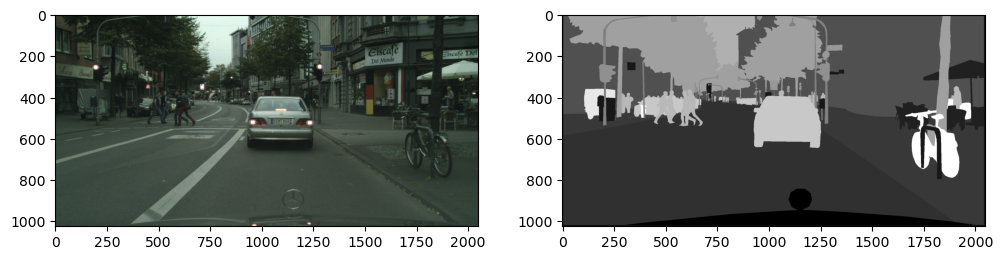

In [4]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset_raw[15][0])
ax[1].imshow(dataset_raw[15][1],cmap='gray')

We see actual input image and target semantic segmented image in the above image.

### utility functions to rearrange the classes

label understanding

https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

function credits: https://github.com/meetps/pytorch-semseg/tree/master/ptsemseg

In [5]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [6]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [7]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [8]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [9]:
#!pip3 install albumentations
#!pip install --user typing_extensions
#pip install typing-extensions
#!pip3 install typing-extensions
#from typing_extensions import Concatenate

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
    [ A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

In [11]:
# custom class to import 
class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)

In [12]:
dataset = MyClass('./data', split='train', mode='fine',
                     target_type='semantic', transforms=transform)

img,seg = dataset[15]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


In [13]:
dataset

Dataset MyClass
    Number of datapoints: 480
    Root location: ./data
    Split: train
    Mode: gtFine
    Type: ['semantic']
    Compose([
  Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


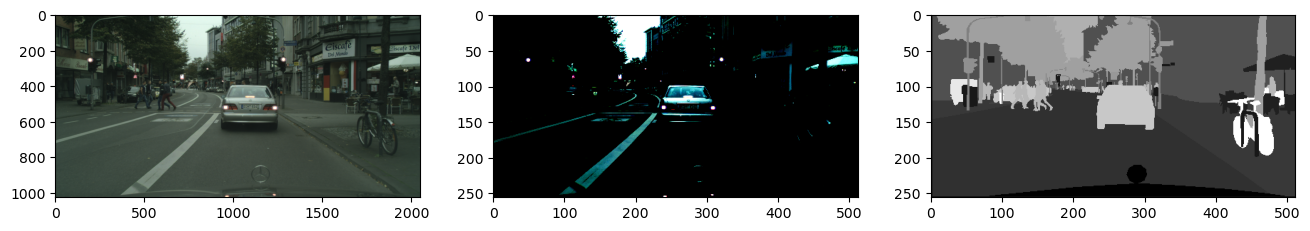

In [14]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(16,8))
ax[0].imshow(dataset_raw[15][0])
ax[1].imshow(img.permute(1, 2, 0))
ax[2].imshow(seg,cmap='gray')

We see actual image, normalized input image and target semantic segmented image in the above image.

In [15]:
#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  5,  7,  8,  9, 11, 17, 19, 20, 21, 23, 24, 26, 30, 33],
       dtype=torch.uint8)
17


In [16]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  6,  7,  8,  9, 11, 12, 14, 19], dtype=torch.uint8)
12


In [17]:
#let do coloring
res1=decode_segmap(res.clone())

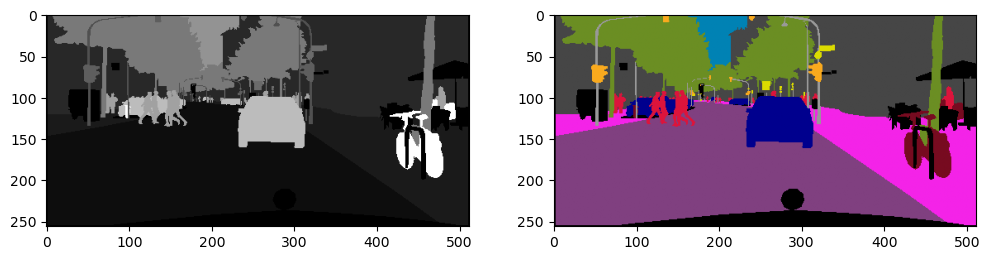

In [18]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

# training

In [19]:
# model=torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
# model
#!pip install segmentation_models_pytorch
#!pip install pytorch-lightning

In [20]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True) 

In [21]:
len(train_dataloader)

24

In [22]:
#Model = models.segmentation.deeplabv3_resnet101(pretrained=1)
#Model = models.segmentation.deeplabv3_resnet50(pretrained=1,in_channels=3,classes=n_classes)

In [31]:
Model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet",
                 in_channels=3, classes=n_classes    )

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Aman_Kumar2/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [32]:
optimizer = torch.optim.AdamW(Model.parameters(), lr=1e-3)
metrics = torchmetrics.JaccardIndex(num_classes=n_classes)
criterion= smp.losses.DiceLoss(mode='multiclass')

In [33]:
Model.eval()

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [34]:
for epoch in range(50):  # loop over the dataset multiple times
    print('epoch', epoch)

    running_loss = 0.0
    running_iou = 0.0
    for i, data in enumerate(train_dataloader, 0):
        
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Model(inputs)
        
        #if isinstance(outputs, OrderedDict):
        #outputs = outputs['out']
        segment=encode_segmap(labels)
        loss=criterion(outputs,segment.long())
        iou=metrics(outputs,segment)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_iou += iou.item()
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, loss.item()),
              ', IoU:', iou.item())
    #print('net_loss:', running_loss/24, 'net_iou', running_iou/24 )  

print('Finished Training')
torch.save(Model.state_dict(), 'model_trained_incep.pth')

epoch 0
[1,     1] loss: 0.974 , IoU: 0.003296696115285158
[1,     2] loss: 0.968 , IoU: 0.007792503573000431
[1,     3] loss: 0.980 , IoU: 0.003653415711596608
[1,     4] loss: 0.969 , IoU: 0.011750294826924801
[1,     5] loss: 0.969 , IoU: 0.010847603902220726
[1,     6] loss: 0.966 , IoU: 0.008274435997009277
[1,     7] loss: 0.864 , IoU: 0.010942360386252403
[1,     8] loss: 0.909 , IoU: 0.013140852563083172
[1,     9] loss: 0.905 , IoU: 0.021360190585255623
[1,    10] loss: 0.904 , IoU: 0.024734925478696823
[1,    11] loss: 0.948 , IoU: 0.02389565296471119
[1,    12] loss: 0.938 , IoU: 0.024954814463853836
[1,    13] loss: 0.888 , IoU: 0.030401695519685745
[1,    14] loss: 0.883 , IoU: 0.038408033549785614
[1,    15] loss: 0.924 , IoU: 0.03796854242682457
[1,    16] loss: 0.920 , IoU: 0.03653819486498833
[1,    17] loss: 0.921 , IoU: 0.0434817373752594
[1,    18] loss: 0.916 , IoU: 0.04096747189760208
[1,    19] loss: 0.864 , IoU: 0.05678769201040268
[1,    20] loss: 0.946 , IoU: 

[7,    21] loss: 0.704 , IoU: 0.24300289154052734
[7,    22] loss: 0.607 , IoU: 0.23817697167396545
[7,    23] loss: 0.656 , IoU: 0.2422291785478592
[7,    24] loss: 0.706 , IoU: 0.24727515876293182
epoch 7
[8,     1] loss: 0.652 , IoU: 0.2403724640607834
[8,     2] loss: 0.658 , IoU: 0.24109990894794464
[8,     3] loss: 0.639 , IoU: 0.25585728883743286
[8,     4] loss: 0.686 , IoU: 0.262273371219635
[8,     5] loss: 0.684 , IoU: 0.25997257232666016
[8,     6] loss: 0.705 , IoU: 0.242366224527359
[8,     7] loss: 0.699 , IoU: 0.24430255591869354
[8,     8] loss: 0.649 , IoU: 0.246128648519516
[8,     9] loss: 0.686 , IoU: 0.2634778618812561
[8,    10] loss: 0.697 , IoU: 0.25380939245224
[8,    11] loss: 0.723 , IoU: 0.22214646637439728
[8,    12] loss: 0.703 , IoU: 0.24160556495189667
[8,    13] loss: 0.645 , IoU: 0.24684801697731018
[8,    14] loss: 0.689 , IoU: 0.25655314326286316
[8,    15] loss: 0.718 , IoU: 0.23234769701957703
[8,    16] loss: 0.703 , IoU: 0.2454523742198944
[8,  

[14,    16] loss: 0.569 , IoU: 0.3120318055152893
[14,    17] loss: 0.642 , IoU: 0.2883974015712738
[14,    18] loss: 0.636 , IoU: 0.3012557923793793
[14,    19] loss: 0.637 , IoU: 0.29524102807044983
[14,    20] loss: 0.593 , IoU: 0.2950282692909241
[14,    21] loss: 0.552 , IoU: 0.3353345990180969
[14,    22] loss: 0.592 , IoU: 0.29178035259246826
[14,    23] loss: 0.624 , IoU: 0.3030988276004791
[14,    24] loss: 0.583 , IoU: 0.2988625466823578
epoch 14
[15,     1] loss: 0.513 , IoU: 0.32054445147514343
[15,     2] loss: 0.633 , IoU: 0.2989673912525177
[15,     3] loss: 0.649 , IoU: 0.2806161344051361
[15,     4] loss: 0.631 , IoU: 0.3027067482471466
[15,     5] loss: 0.566 , IoU: 0.3165639638900757
[15,     6] loss: 0.614 , IoU: 0.3156318962574005
[15,     7] loss: 0.635 , IoU: 0.30004623532295227
[15,     8] loss: 0.581 , IoU: 0.30998659133911133
[15,     9] loss: 0.653 , IoU: 0.2798347771167755
[15,    10] loss: 0.629 , IoU: 0.306063175201416
[15,    11] loss: 0.631 , IoU: 0.3016

[21,    10] loss: 0.577 , IoU: 0.3413221538066864
[21,    11] loss: 0.597 , IoU: 0.34059610962867737
[21,    12] loss: 0.596 , IoU: 0.32527559995651245
[21,    13] loss: 0.515 , IoU: 0.3621658980846405
[21,    14] loss: 0.571 , IoU: 0.35200875997543335
[21,    15] loss: 0.510 , IoU: 0.3660421371459961
[21,    16] loss: 0.522 , IoU: 0.3504997789859772
[21,    17] loss: 0.527 , IoU: 0.34867769479751587
[21,    18] loss: 0.514 , IoU: 0.3161582350730896
[21,    19] loss: 0.529 , IoU: 0.3512742221355438
[21,    20] loss: 0.600 , IoU: 0.32602471113204956
[21,    21] loss: 0.576 , IoU: 0.35082852840423584
[21,    22] loss: 0.608 , IoU: 0.3212670683860779
[21,    23] loss: 0.610 , IoU: 0.3210659921169281
[21,    24] loss: 0.614 , IoU: 0.3172384202480316
epoch 21
[22,     1] loss: 0.535 , IoU: 0.342953622341156
[22,     2] loss: 0.563 , IoU: 0.3581527769565582
[22,     3] loss: 0.597 , IoU: 0.3332308232784271
[22,     4] loss: 0.508 , IoU: 0.36478549242019653
[22,     5] loss: 0.626 , IoU: 0.30

[28,     4] loss: 0.541 , IoU: 0.3820800185203552
[28,     5] loss: 0.530 , IoU: 0.3987693190574646
[28,     6] loss: 0.529 , IoU: 0.398960679769516
[28,     7] loss: 0.558 , IoU: 0.36766770482063293
[28,     8] loss: 0.559 , IoU: 0.3642753064632416
[28,     9] loss: 0.519 , IoU: 0.352985680103302
[28,    10] loss: 0.550 , IoU: 0.37060612440109253
[28,    11] loss: 0.570 , IoU: 0.3591371178627014
[28,    12] loss: 0.550 , IoU: 0.3670424818992615
[28,    13] loss: 0.564 , IoU: 0.3640865683555603
[28,    14] loss: 0.487 , IoU: 0.3876490592956543
[28,    15] loss: 0.562 , IoU: 0.36154937744140625
[28,    16] loss: 0.465 , IoU: 0.35807281732559204
[28,    17] loss: 0.446 , IoU: 0.3795721232891083
[28,    18] loss: 0.492 , IoU: 0.3884912133216858
[28,    19] loss: 0.514 , IoU: 0.3659285306930542
[28,    20] loss: 0.516 , IoU: 0.3585783541202545
[28,    21] loss: 0.577 , IoU: 0.34577351808547974
[28,    22] loss: 0.551 , IoU: 0.3767969012260437
[28,    23] loss: 0.554 , IoU: 0.36844679713249

[34,    22] loss: 0.588 , IoU: 0.33167916536331177
[34,    23] loss: 0.526 , IoU: 0.35310912132263184
[34,    24] loss: 0.567 , IoU: 0.35021722316741943
epoch 34
[35,     1] loss: 0.567 , IoU: 0.35177522897720337
[35,     2] loss: 0.606 , IoU: 0.3095479905605316
[35,     3] loss: 0.567 , IoU: 0.3523455560207367
[35,     4] loss: 0.597 , IoU: 0.3247864246368408
[35,     5] loss: 0.545 , IoU: 0.37234896421432495
[35,     6] loss: 0.564 , IoU: 0.3555562496185303
[35,     7] loss: 0.573 , IoU: 0.34937089681625366
[35,     8] loss: 0.564 , IoU: 0.3540232479572296
[35,     9] loss: 0.549 , IoU: 0.3624597489833832
[35,    10] loss: 0.566 , IoU: 0.3441002666950226
[35,    11] loss: 0.544 , IoU: 0.37078857421875
[35,    12] loss: 0.564 , IoU: 0.35512658953666687
[35,    13] loss: 0.548 , IoU: 0.37432563304901123
[35,    14] loss: 0.549 , IoU: 0.37024804949760437
[35,    15] loss: 0.575 , IoU: 0.34672895073890686
[35,    16] loss: 0.499 , IoU: 0.3719900846481323
[35,    17] loss: 0.470 , IoU: 0.

[41,    16] loss: 0.592 , IoU: 0.33832675218582153
[41,    17] loss: 0.605 , IoU: 0.32526183128356934
[41,    18] loss: 0.568 , IoU: 0.3551916480064392
[41,    19] loss: 0.513 , IoU: 0.35262331366539
[41,    20] loss: 0.504 , IoU: 0.358718603849411
[41,    21] loss: 0.567 , IoU: 0.3476448953151703
[41,    22] loss: 0.554 , IoU: 0.3663291335105896
[41,    23] loss: 0.496 , IoU: 0.3786495625972748
[41,    24] loss: 0.547 , IoU: 0.37377968430519104
epoch 41
[42,     1] loss: 0.489 , IoU: 0.37033867835998535
[42,     2] loss: 0.471 , IoU: 0.3482370972633362
[42,     3] loss: 0.543 , IoU: 0.3691624104976654
[42,     4] loss: 0.552 , IoU: 0.358564555644989
[42,     5] loss: 0.492 , IoU: 0.37795543670654297
[42,     6] loss: 0.530 , IoU: 0.3858262002468109
[42,     7] loss: 0.506 , IoU: 0.3668491244316101
[42,     8] loss: 0.538 , IoU: 0.37662702798843384
[42,     9] loss: 0.530 , IoU: 0.3843607008457184
[42,    10] loss: 0.555 , IoU: 0.3601430058479309
[42,    11] loss: 0.511 , IoU: 0.362231

[48,    10] loss: 0.550 , IoU: 0.3604917526245117
[48,    11] loss: 0.484 , IoU: 0.3796672523021698
[48,    12] loss: 0.427 , IoU: 0.42386969923973083
[48,    13] loss: 0.500 , IoU: 0.4124392569065094
[48,    14] loss: 0.481 , IoU: 0.3842369019985199
[48,    15] loss: 0.516 , IoU: 0.39006003737449646
[48,    16] loss: 0.510 , IoU: 0.40108609199523926
[48,    17] loss: 0.493 , IoU: 0.415333092212677
[48,    18] loss: 0.563 , IoU: 0.3558259606361389
[48,    19] loss: 0.532 , IoU: 0.39472994208335876
[48,    20] loss: 0.492 , IoU: 0.41622939705848694
[48,    21] loss: 0.463 , IoU: 0.3939986526966095
[48,    22] loss: 0.459 , IoU: 0.40074101090431213
[48,    23] loss: 0.399 , IoU: 0.41326284408569336
[48,    24] loss: 0.534 , IoU: 0.37587589025497437
epoch 48
[49,     1] loss: 0.450 , IoU: 0.405437171459198
[49,     2] loss: 0.510 , IoU: 0.3984888195991516
[49,     3] loss: 0.517 , IoU: 0.39615339040756226
[49,     4] loss: 0.514 , IoU: 0.3941662609577179
[49,     5] loss: 0.482 , IoU: 0.4

In [ ]:
gc.collect()

In [35]:
Model.load_state_dict(torch.load('model_trained_incep.pth'))
Model.eval()

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [36]:
test_class = MyClass('./data', split='train', mode='fine', target_type='semantic',transforms=transform)

In [37]:
test_loader=DataLoader(test_class, batch_size=20, shuffle=False)

In [38]:
len(test_loader)

24

In [39]:
#model=Model.cuda()
Model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        outputs=Model(img)
        segment=encode_segmap(seg)
        loss=criterion(outputs,segment.long())
        iou=metrics(outputs,segment)
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, loss.item()),
              ', IoU:', iou.item())
        
print(img.shape,seg.shape,outputs.shape)   

[50,    24] loss: 0.367 , IoU: 0.43730077147483826
[50,    24] loss: 0.361 , IoU: 0.44322705268859863
[50,    24] loss: 0.356 , IoU: 0.4111233353614807
[50,    24] loss: 0.442 , IoU: 0.4145887792110443
[50,    24] loss: 0.370 , IoU: 0.39844849705696106
[50,    24] loss: 0.413 , IoU: 0.4016685485839844
[50,    24] loss: 0.483 , IoU: 0.3908175230026245
[50,    24] loss: 0.346 , IoU: 0.4660813808441162
[50,    24] loss: 0.437 , IoU: 0.4209640920162201
[50,    24] loss: 0.479 , IoU: 0.3794284164905548
[50,    24] loss: 0.422 , IoU: 0.4376102089881897
[50,    24] loss: 0.499 , IoU: 0.41006389260292053
[50,    24] loss: 0.526 , IoU: 0.3357221484184265
[50,    24] loss: 0.492 , IoU: 0.37492793798446655
[50,    24] loss: 0.413 , IoU: 0.44323045015335083
[50,    24] loss: 0.367 , IoU: 0.3939102292060852
[50,    24] loss: 0.424 , IoU: 0.3952203094959259
[50,    24] loss: 0.474 , IoU: 0.43145227432250977
[50,    24] loss: 0.382 , IoU: 0.4258118271827698
[50,    24] loss: 0.477 , IoU: 0.4309577941

In [40]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


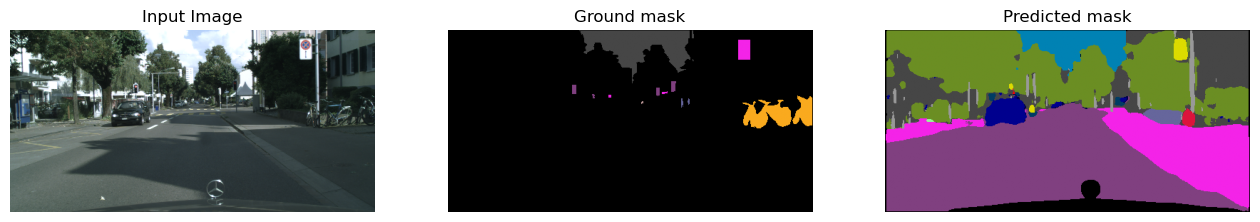

In [43]:

sample=16
invimg=inv_normalize(img[sample])
outputx=outputs.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')